In [25]:
import pandas as pd
import numpy as np
from collections import Counter
from numpy import where
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from random import randrange, uniform
import time

In [26]:
credit_train = pd.read_csv('./dataset/creditcard.csv')
is_fraud = (credit_train['Class'] == 1)
non_fraud = credit_train[~is_fraud]
fraud = credit_train[is_fraud]

In [27]:
def SMUTE(X_maj, y_maj, n_smute):
    X_maj_prime = X_maj.copy().reset_index(drop=True)
    y_maj_prime = y_maj.copy().reset_index(drop=True)
    
    x3_y = y_maj_prime.sample().copy()
    
    knn = NearestNeighbors(n_neighbors=6)
    
    tic = time.perf_counter()
    while((len(X_maj) - len(X_maj_prime)) < n_smute):
        x1_id = X_maj_prime.sample().index.item()
        x1 = X_maj_prime.iloc[x1_id]
        knn.fit(X_maj_prime.to_numpy(), y_maj_prime.to_numpy())
        distances, indices = knn.kneighbors(x1.to_numpy().reshape(1, -1))
        indices = indices[0][1:6]
        x2_id = indices[randrange(5)]
        x2 = X_maj_prime.iloc[x2_id]
        r = uniform(0, 1)
        x3 = x1 + (r * (x2 - x1))

        X_maj_prime = X_maj_prime.drop([x1_id, x2_id]).reset_index(drop=True)
        y_maj_prime = y_maj_prime.drop([x1_id, x2_id]).reset_index(drop=True)

        X_maj_prime = X_maj_prime.append(x3, ignore_index=True)
        y_maj_prime = y_maj_prime.append(x3_y, ignore_index=True)

    toc = time.perf_counter()
    print(f"SMUTE: {toc - tic:0.4f} seconds")
    
    return X_maj_prime, y_maj_prime

In [28]:
def SMOTE(X_min, y_min, n_smote):
    X_min = X_min.reset_index(drop=True)
    y_min = y_min.reset_index(drop=True)
    
    X_min_prime = X_min.copy()
    y_min_prime = y_min.copy()
        
    x3_y = y_min_prime.sample().copy()
    
    knn = NearestNeighbors(n_neighbors=6)
    knn.fit(X_min.to_numpy(), y_min.to_numpy())

    tic = time.perf_counter()
    while((len(X_min_prime) - len(X_min)) < n_smote):
        x1_id = X_min.sample().index.item()
        x1 = X_min.iloc[x1_id]
        _, indices = knn.kneighbors(x1.to_numpy().reshape(1, -1))
        indices = indices[0][1:6]
        x2_id = indices[randrange(5)]
        x2 = X_min.iloc[x2_id]
        r = uniform(0, 1)
        x3 = x1 + (r * (x2 - x1))
        X_min_prime = X_min_prime.append(x3, ignore_index=True)
        y_min_prime = y_min_prime.append(x3_y, ignore_index=True)
        
    toc = time.perf_counter()
    print(f"SMOTE: {toc - tic:0.4f} seconds")
    
    return X_min_prime, y_min_prime

In [29]:
def CSMOUTE(majority, minority, ratio):
    tic = time.perf_counter()
    X_maj = majority.drop(columns=['Class']).copy()
    y_maj = majority['Class'].copy()
    
    X_min = minority.drop(columns=['Class']).copy()
    y_min = minority['Class'].copy()
    
    n = len(X_maj) - len(X_min)
    n_smote = round(n * ratio)
    n_smute = n - n_smote
    
    X_min_prime, y_min_prime = SMOTE(X_min, y_min, n_smote)
    X_maj_prime, y_maj_prime = SMUTE(X_maj, y_maj, n_smute)
    
    toc = time.perf_counter()
    print(f"Overall: {toc - tic:0.4f} seconds")
    
    return X_maj_prime, y_maj_prime, X_min_prime, y_min_prime

In [30]:
X_maj_prime, y_maj_prime, X_min_prime, y_min_prime = CSMOUTE(non_fraud, fraud, 1)

SMOTE: 3297.2283 seconds
SMUTE: 0.0000 seconds
Overall: 3297.3012 seconds


In [7]:
def plot(counter, a, b, data, labels, x, y):
    alphas = [a, b]
    for label, _ in counter.items():
        row_ix = where(labels == label)[0]
        plt.scatter(
            data.iloc[row_ix][x],
            data.iloc[row_ix][y],
            label=str(label),
            alpha=alphas[label]
        )
    plt.legend()
    plt.title('CreditCard.csv')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

In [8]:
from collections import Counter
import matplotlib.pyplot as plt

In [9]:
counter = Counter(y_min_prime)

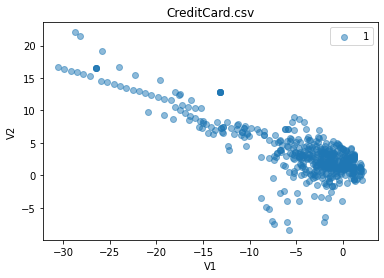

In [22]:
plot(counter, 0.5, 0.5, X_min_prime, y_min_prime, 'V1', 'V2')